# Brain Tumor Classification with a Convolutional Neural Network

## 1. Import Necessary Libraries

In [52]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import visualkeras
import os
import random
import warnings
warnings.filterwarnings("ignore")

## 2. Set Global Parameters

In [4]:
# Model Training
IMAGE_SIZE = (150, 150)  
BATCH_SIZE = 32         
EPOCHS = 40
NUM_CLASSES = 4

# Setting seed for consistent results
SEED = 42
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

## 3. Load and Preprocess Data

In [7]:
# Load Training and Testing Data
os.environ['DATA_PATH'] = './data'
train_dir = os.path.join(os.environ['DATA_PATH'], 'Training')
test_dir = os.path.join(os.environ['DATA_PATH'], 'Testing')

In [54]:
# Preprocess Data 
train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="training",
        seed=SEED,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,  
        label_mode='categorical'
    )

val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="validation",
        seed=SEED,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE, 
        label_mode='categorical'
    )

test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        seed=SEED,
        image_size=IMAGE_SIZE,
        batch_size=16,  
        label_mode='categorical'
    )

# Pull Class Names for Sample Images/Visualizations
class_names = train_ds.class_names

def normalize(image, label):
        
        # Convert to float32 and normalize
        image = tf.cast(image, tf.float32) / 255.0
        
        return image, label

# Apply Normalization
train_ds = train_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


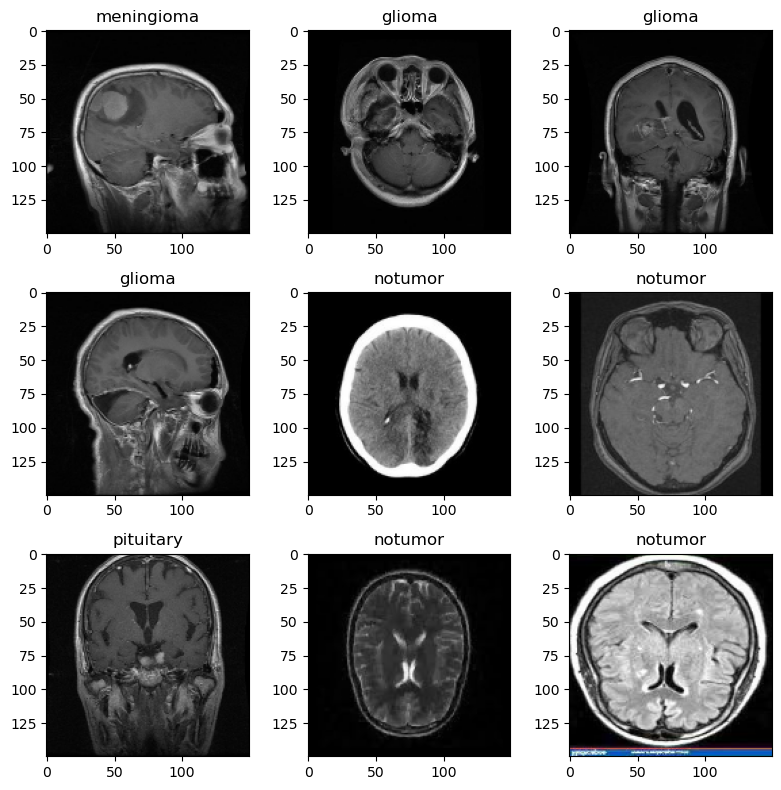

In [11]:
imgs, labs = next(iter(test_ds))
label_ids = np.argmax(labs, axis=1)

# Sample Images
plt.figure(figsize=(8,8))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(imgs[i].numpy())  
    plt.title(class_names[label_ids[i]])
    plt.axis("on")
plt.tight_layout()
plt.show()

## 4. Build Model

In [14]:
model = tf.keras.Sequential([

        # Input layer
        tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    
        # Convolutional layer 1
        tf.keras.layers.Conv2D(32, (4, 4), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Dropout(0.25),

        # Convolutional layer 2
        tf.keras.layers.Conv2D(64, (4, 4), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Dropout(0.25),

        # Convolutional layer 3
        tf.keras.layers.Conv2D(128, (4, 4), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        tf.keras.layers.Dropout(0.25),

        # Convolutional layer 4
        tf.keras.layers.Conv2D(128, (4, 4), activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),

        # Full connect layers
        tf.keras.layers.Dense(512, activation="relu", 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
    ])

In [16]:
# Model Compilation 
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0005,
        beta_1=0.9,  
        beta_2=0.999  
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 'precision', 'recall']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 147, 147, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499,428 (1.91 MB)

 Trainable params: 497,700 (1.90 MB)

 Non-trainable params: 1,728 (6.75 KB)

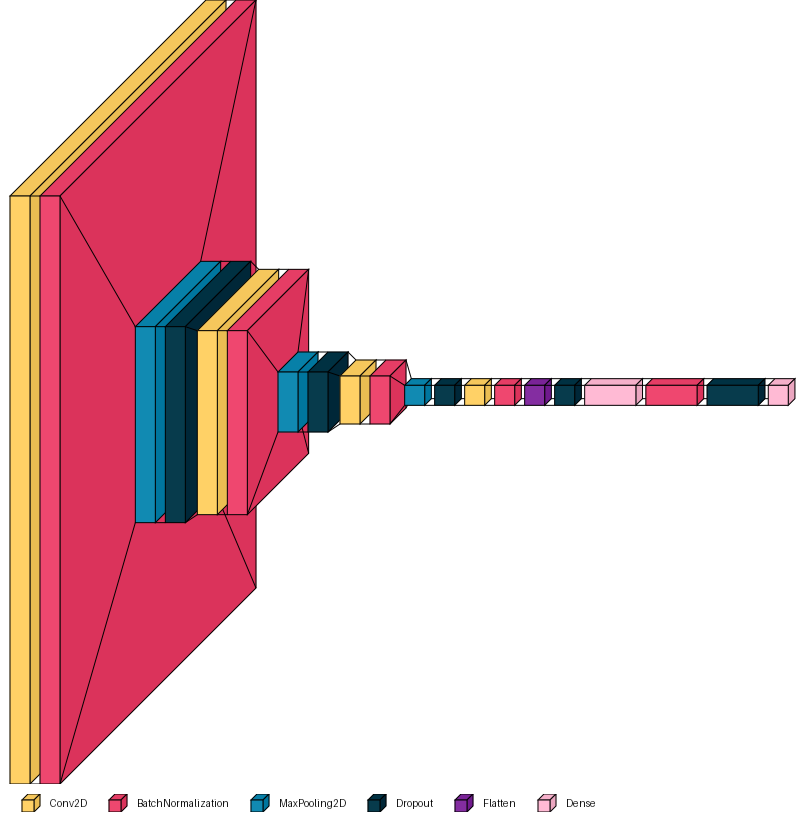

In [18]:
# Visualize Model
visualkeras.layered_view(model, to_file='model_viz.png', legend=True)

## 5. Train Model

In [21]:
# Create Callbacks
callbacks = [
    # Early Stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-4,
        patience=5,     
        verbose=1,
        restore_best_weights=True 
    ),

    # Learning Rate Reduction
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,     
        patience=5,
        min_lr=1e-6,    
            
    )
]

# Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - accuracy: 0.4932 - auc: 0.7530 - loss: 3.3965 - precision: 0.5230 - recall: 0.4419 - val_accuracy: 0.4335 - val_auc: 0.5983 - val_loss: 4.2873 - val_precision: 0.4422 - val_recall: 0.4291 - learning_rate: 5.0000e-04
Epoch 2/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 167ms/step - accuracy: 0.7125 - auc: 0.9052 - loss: 2.4002 - precision: 0.7354 - recall: 0.6754 - val_accuracy: 0.2644 - val_auc: 0.5665 - val_loss: 5.1575 - val_precision: 0.2673 - val_recall: 0.2644 - learning_rate: 5.0000e-04
Epoch 3/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.7661 - auc: 0.9372 - loss: 1.9236 - precision: 0.7871 - recall: 0.7359 - val_accuracy: 0.5342 - val_auc: 0.7944 - val_loss: 2.6120 - val_precision: 0.5536 - val_recall: 0.4974 - learning_rate: 5.0000e-04
Epoch 4/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 167ms/step - accuracy: 0.7858 - auc: 0.9483 - loss: 1.6173 - precision: 0.8042 - recall: 0.7643 - val_accuracy: 0.5902 - val_auc: 0.8236 

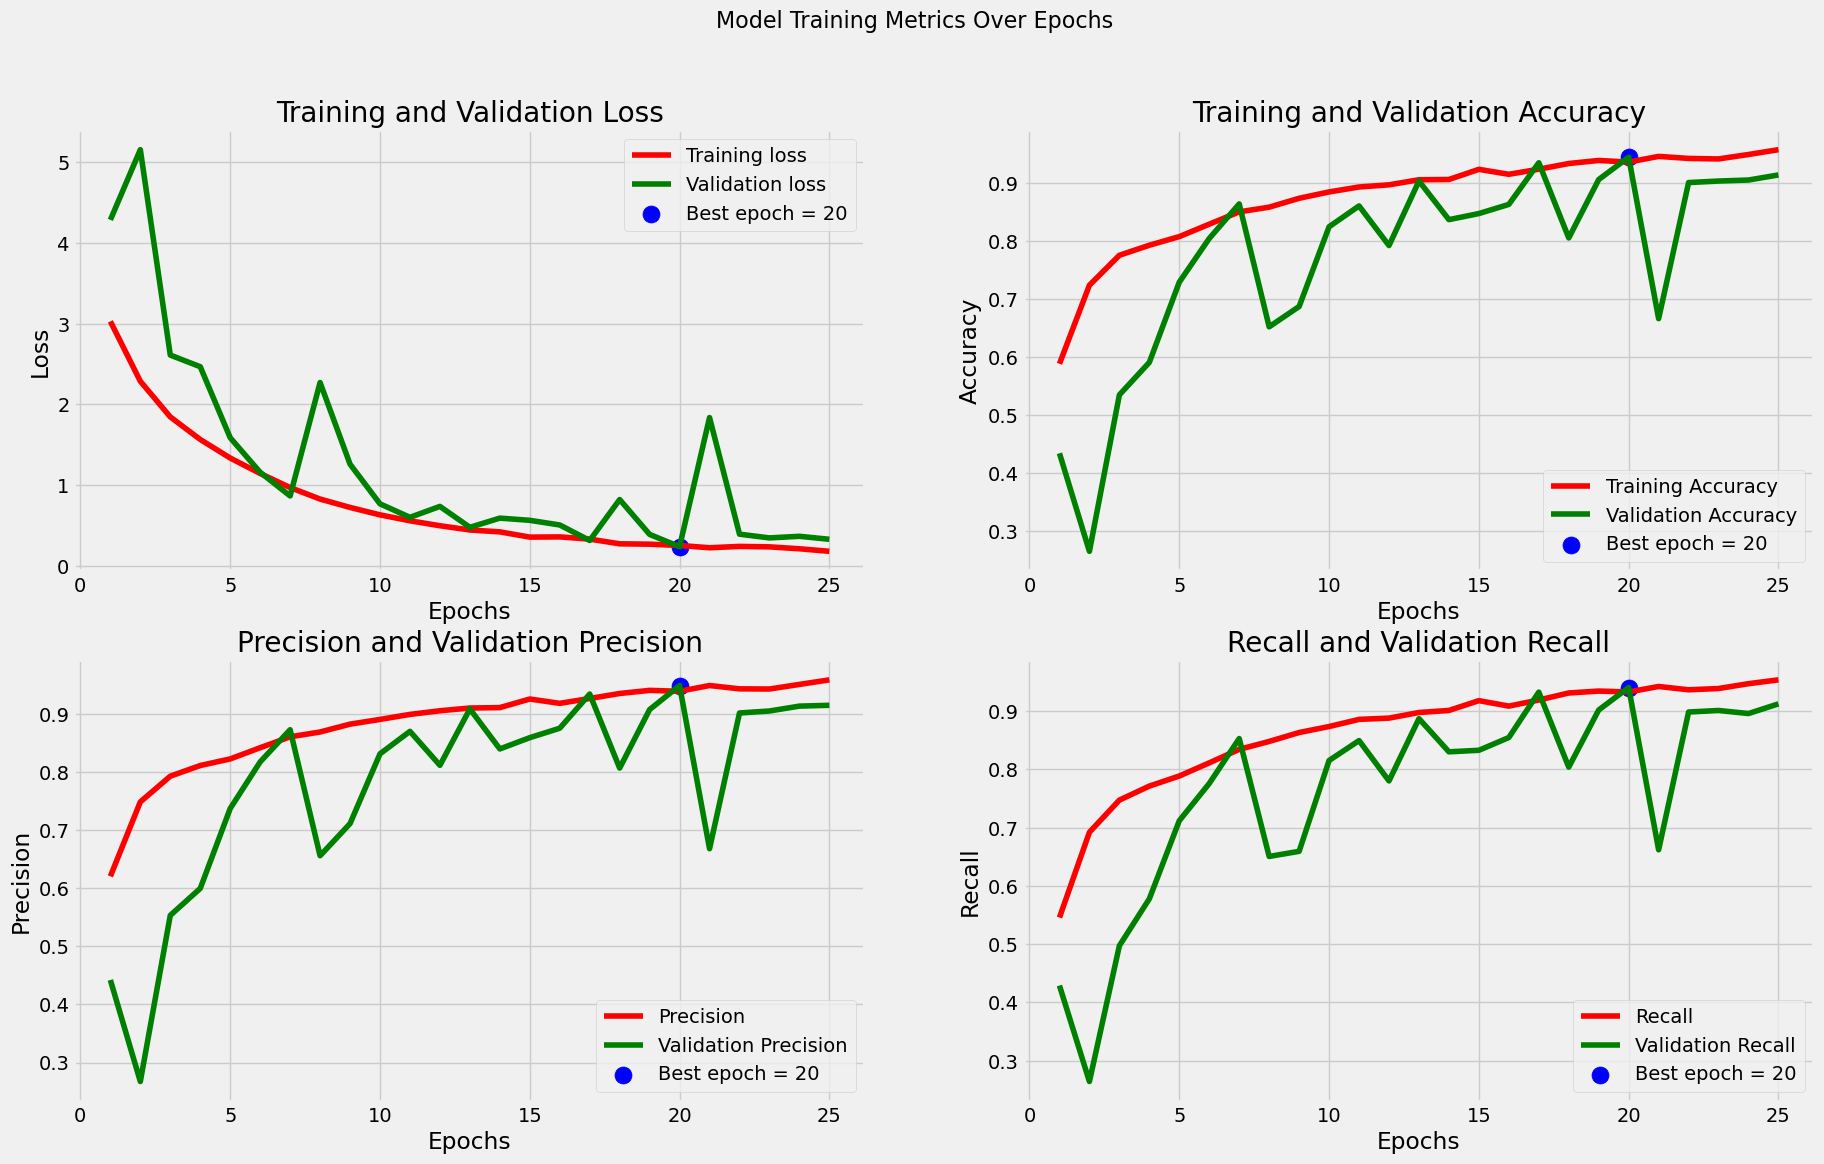

In [29]:
# Visualize Training Performance
train_acc = history.history['accuracy']
train_loss = history.history['loss']
train_pre = history.history['precision']
train_recall = history.history['recall']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision']
val_recall = history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(train_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, train_pre, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, train_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

## 6. Evaluate Model

In [34]:
# Evaluate
train_score = model.evaluate(train_ds, verbose=1)
valid_score = model.evaluate(val_ds, verbose=1)
test_score = model.evaluate(test_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9785 - auc: 0.9992 - loss: 0.1493 - precision: 0.9796 - recall: 0.9767
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9519 - auc: 0.9960 - loss: 0.2237 - precision: 0.9562 - recall: 0.9502
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9224 - auc: 0.9929 - loss: 0.2747 - precision: 0.9286 - recall: 0.9158
Train Loss: 0.1466
Train Accuracy: 98.10%
--------------------
Validation Loss: 0.2379
Validation Accuracy: 94.40%
--------------------
Test Loss: 0.2548
Test Accuracy: 93.21%


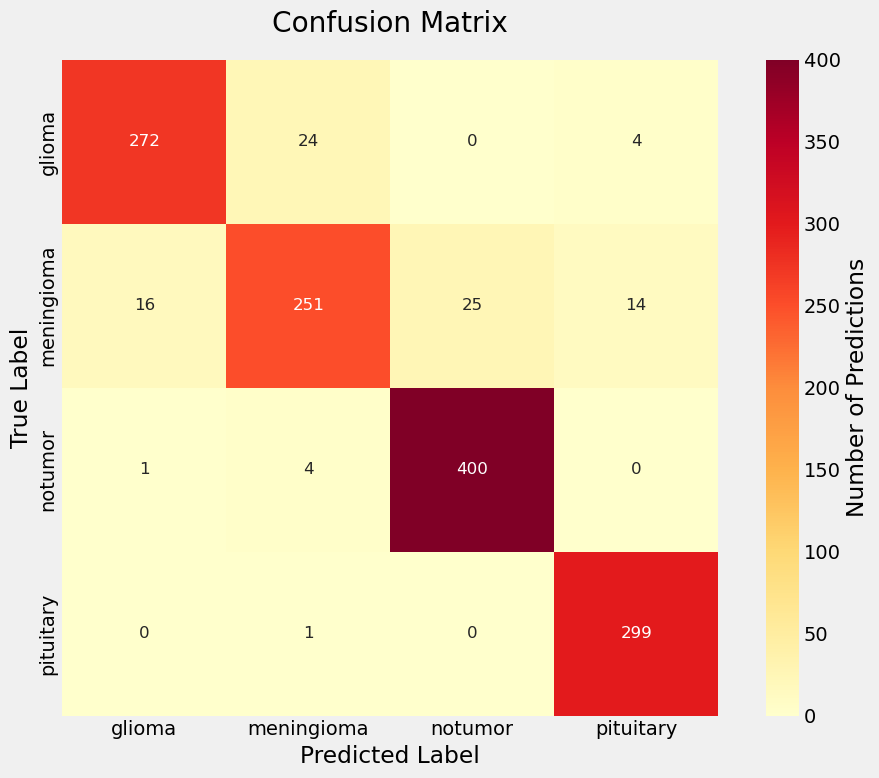

In [58]:
# Get predictions and true labels
y_pred = []
y_true = []
    
# Iterate through the dataset
for images, labels in test_ds:
    # Get predictions for this batch
    predictions = model.predict(images, verbose=0)
    # Convert predictions and labels to class indices
    pred_indices = np.argmax(predictions, axis=1)
    true_indices = np.argmax(labels, axis=1)
        
    y_pred.extend(pred_indices)
    y_true.extend(true_indices)
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
    
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='YlOrRd',
            cbar_kws={'label': 'Number of Predictions'},
            annot_kws={'size': 12},
            square=True)
    
plt.title('Confusion Matrix', pad=20)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
    
# Adjust layout to prevent label cutoff
plt.tight_layout()

In [60]:
# Print Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.94      0.91      0.92       300
  meningioma       0.90      0.82      0.86       306
     notumor       0.94      0.99      0.96       405
   pituitary       0.94      1.00      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



## 7. Test Model

In [98]:
# Make a Prediction
def predict_image(model, img_path, image_size, class_names):
    # Load & resize
    img = tf.keras.utils.load_img(img_path, target_size=image_size)
    
    # Convert to array & normalize to [0,1]
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    
    # Add batch dimension
    img_batch = np.expand_dims(img_array, axis=0)
    
    # Run model
    preds = model.predict(img_batch)           
    pred_idx = np.argmax(preds[0])             
    pred_label = class_names[pred_idx]        
    confidence = preds[0][pred_idx]            
    
    return img_array, pred_label, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


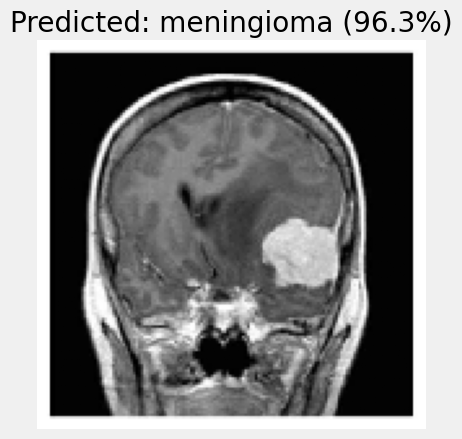

In [90]:
# Test
img_path = './data/Testing/meningioma/Te-me_0014.jpg'
img, label, conf = predict_image(model, img_path, IMAGE_SIZE, class_names)

plt.imshow(img)
plt.title(f'Predicted: {label} ({conf:.1%})')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


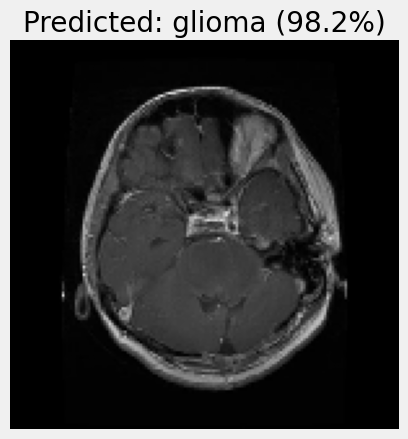

In [92]:
img_path = './data/Testing/glioma/Te-gl_0010.jpg'
img, label, conf = predict_image(model, img_path, IMAGE_SIZE, class_names)

plt.imshow(img)
plt.title(f'Predicted: {label} ({conf:.1%})')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


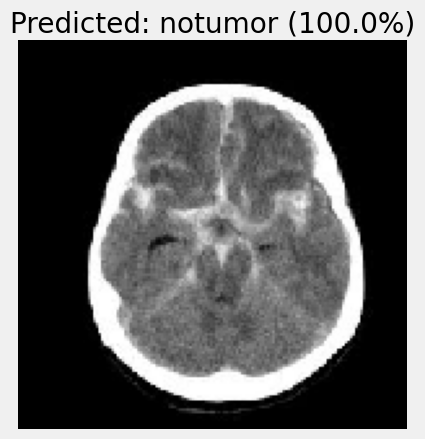

In [94]:
img_path = './data/Testing/notumor/Te-no_0011.jpg'
img, label, conf = predict_image(model, img_path, IMAGE_SIZE, class_names)

plt.imshow(img)
plt.title(f'Predicted: {label} ({conf:.1%})')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


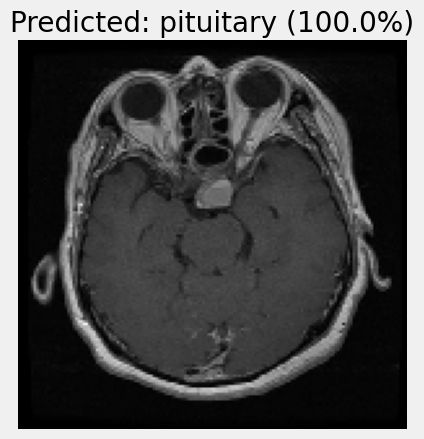

In [96]:
img_path = './data/Testing/pituitary/Te-pi_0027.jpg'
img, label, conf = predict_image(model, img_path, IMAGE_SIZE, class_names)

plt.imshow(img)
plt.title(f'Predicted: {label} ({conf:.1%})')
plt.axis('off')
plt.show()